# Quantile Regression

*Example shamelessly taken from statsmodels documentation and adapted: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html*


This example page shows how to use statsmodels' QuantReg class to replicate parts of the analysis published in

    Koenker, Roger and Kevin F. Hallock. "Quantile Regressioin". Journal of Economic Perspectives, Volume 15, Number 4, Fall 2001, Pages 143–156

We are interested in the relationship between income and expenditures on food for a sample of working class Belgian households in 1857 (the Engel data).

In [1]:
%matplotlib inline

from __future__ import print_function
import patsy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg

data = sm.datasets.engel.load_pandas().data
data.head()



,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


## Least Absolute Deviation
The LAD model is a special case of quantile regression where q=0.5

In [2]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Tue, 12 Mar 2019   No. Observations:                  235
Time:                        18:48:00   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


## Visualizing the results
We estimate the quantile regression model for many quantiles between .05 and .95, and compare best fit line from each of these models to Ordinary Least Squares results.

In [3]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['income'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q           a         b        lb        ub
0  0.05  124.880095  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033435  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': 147.47538852370573, 'b': 0.48517842367692354, 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


## First plot
This plot compares best fit lines for 10 quantile regression models to the least squares fit. As Koenker and Hallock (2001) point out, we see that:

1. Food expenditure increases with income
2. The dispersion of food expenditure increases with income
3. The least squares estimates fit low income observations quite poorly (i.e. the OLS line passes over most low income households)


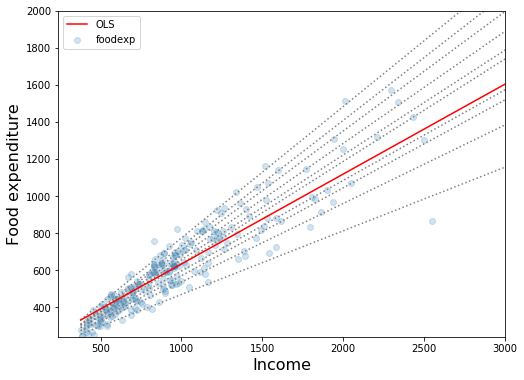

In [4]:
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);

## Second plot
The dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line). The red lines represent OLS regression results along with their 95% confindence interval.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of income on food expenditure may not be constant across the distribution.

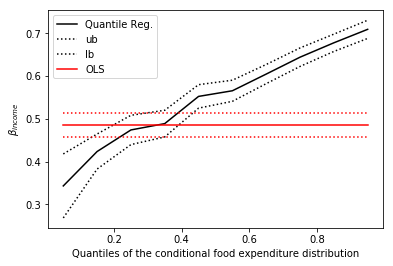

In [5]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()

In [7]:
models.ub

0    0.418090
1    0.464636
2    0.508306
3    0.520043
4    0.579835
5    0.590247
6    0.626982
7    0.665617
8    0.697823
9    0.730306
Name: ub, dtype: float64

## Own example

In [26]:
data = sm.datasets.scotland.load_pandas().data
data.head()

,YES,COUTAX,UNEMPF,MOR,ACT,GDP,AGE,COUTAX_FEMALEUNEMP
0,60.3,712.0,21.0,105.0,82.4,13566.0,12.3,14952.0
1,52.3,643.0,26.5,97.0,80.2,13566.0,15.3,17039.5
2,53.4,679.0,28.3,113.0,86.3,9611.0,13.9,19215.7
3,57.0,801.0,27.1,109.0,80.4,9483.0,13.6,21707.1
4,68.7,753.0,22.0,115.0,64.7,9265.0,14.6,16566.0


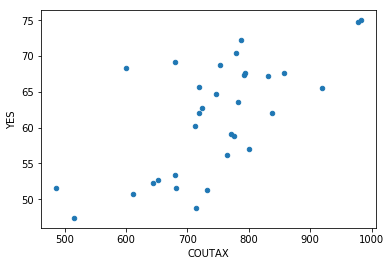

In [27]:
data.plot(y='YES',x='COUTAX', kind='scatter')

In [28]:
mod = smf.quantreg('YES ~ COUTAX', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    YES   Pseudo R-squared:               0.3017
Model:                       QuantReg   Bandwidth:                       9.708
Method:                 Least Squares   Sparsity:                        18.62
Date:                Tue, 12 Mar 2019   No. Observations:                   32
Time:                        19:26:24   Df Residuals:                       30
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.0292     11.386      1.671      0.105      -4.223      42.282
COUTAX         0.0569      0.015      3.761      0.001       0.026       0.088

The condition number is large, 5.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [29]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['COUTAX'], res.params['COUTAX']] + \
            res.conf_int().loc['COUTAX'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('YES ~ COUTAX', data).fit()
ols_ci = ols.conf_int().loc['COUTAX'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['COUTAX'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q         a         b        lb        ub
0  0.05  0.075532  0.075532       NaN       NaN
1  0.15  0.058403  0.058403  0.041805  0.075002
2  0.25  0.050000  0.050000  0.023517  0.076483
3  0.35  0.052830  0.052830  0.024606  0.081055
4  0.45  0.058963  0.058963  0.028083  0.089843
5  0.55  0.054135  0.054135  0.022974  0.085296
6  0.65  0.046951  0.046951  0.013623  0.080280
7  0.75  0.040526  0.040526  0.007617  0.073436
8  0.85  0.027511  0.027511 -0.017649  0.072671
9  0.95  0.017232  0.017232       NaN       NaN
{'a': 25.572791181106123, 'b': 0.04818516717903463, 'lb': 0.02816790505147816, 'ub': 0.0682024293065911}


/opt/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


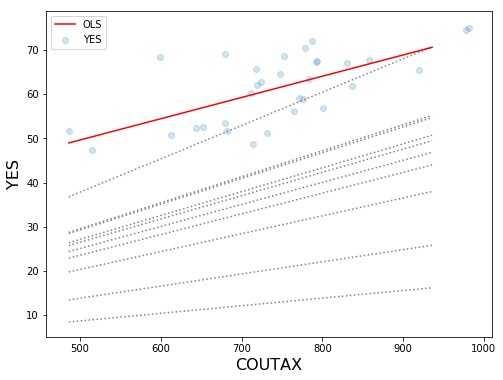

In [31]:
x = np.arange(data.COUTAX.min(), data.COUTAX.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.COUTAX, data.YES, alpha=.2)
#ax.set_xlim((240, 3000))
#ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('COUTAX', fontsize=16)
ax.set_ylabel('YES', fontsize=16);